In [1]:
import model_lib
import os
import params
import data_preparation
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn.metrics as sk
from tqdm import trange
from skimage import io
from skimage.util.shape import view_as_blocks
tfd = tfp.distributions
keras = tf.keras
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

NUM_ClASSES = len(params.brand_models)

## Utils functions

In [2]:
def add_gaussian_noise(image):
    # image must be scaled in [0, 1]
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=(2)/(255), dtype=tf.float32)
    noise_img = image + noise
    return noise_img

In [3]:
def add_salt_pepper_noise(image):
    # Need to produce a copy as to not modify the original image
    image_copy = image.copy()
    row, col, _ = image_copy.shape
    salt_vs_pepper = 0.2
    amount = 0.004
    num_salt = np.ceil(amount * image_copy[0].size * salt_vs_pepper)
    num_pepper = np.ceil(amount * image_copy[0].size * (1.0 - salt_vs_pepper))

    # Add Salt noise
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    image[coords[0], coords[1], :] = 1

    # Add Pepper noise
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    image[coords[0], coords[1], :] = 0

In [4]:
def parse_image(filename, post_processing=None, show_image=True):
    label =  tf.strings.split(filename, os.sep)[-1]
    image = io.imread(filename)
    image = tf.image.convert_image_dtype(image, tf.float32)
    if post_processing == 'jpeg':
        image = tf.image.adjust_jpeg_quality(image, 70)
    elif post_processing == 'blur':
        image = tfa.image.gaussian_filter2d(image, 
                                            filter_shape=[5, 5],
                                            sigma=1.1)
    elif post_processing == 'noise':
        image = add_gaussian_noise(image)
    elif post_processing == 'salt':
        image = add_salt_pepper_noise(image.numpy())
        
    image = tf.clip_by_value(image, 0.0, 1.0)
        
    if show_image:
        plt.figure()
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.xlabel(label.numpy().decode('utf-8'))

    # divide into patches
    v_patch_span = image.shape[0] // 256 * 256
    h_patch_span = image.shape[1] // 256 * 256
    patch_span = min([h_patch_span, v_patch_span, params.patch_span])
    
    center = np.divide(image.shape[:2], 2).astype(int)
    start = np.subtract(center, patch_span/2).astype(int)
    end = np.add(center, patch_span/2).astype(int)
    sub_img = image[start[0]:end[0], start[1]:end[1]]
    sub_img = np.asarray(sub_img)
    patches = view_as_blocks(sub_img[:, :, 1], (256, 256))

    images = patches.reshape((-1, 256, 256))
    images = images[..., tf.newaxis]
    return images, label

In [5]:
def compute_probs(images, num_monte_carlo=30):
    probs = tf.stack([tf.keras.layers.Activation('softmax')(model(images)) for _ in range(num_monte_carlo)], axis=0)
    mean_probs = tf.reduce_mean(probs, axis=0)
    eps = tf.convert_to_tensor(np.finfo(float).eps, dtype=tf.float32)
    sum_log_prob = -tf.reduce_sum(tf.math.multiply(mean_probs, tf.math.log(mean_probs + eps)), axis=1)
    heldout_log_prob = tf.reduce_mean(sum_log_prob)
    print(' ... Held-out nats: {:.3f}'.format(heldout_log_prob))
    
    epistemic_all = 0
    for i in range(probs.shape[1]):
        aleatoric, epistemic = decompose_uncertainties(probs.numpy()[:,i,:])
        epistemic_all += sum(np.diag(epistemic))
    mean_epistemic = epistemic_all/probs.shape[1]
    print('mean epistemic uncertainty: {:.3f}\n'.format(mean_epistemic))
    
    return probs, heldout_log_prob, mean_epistemic

In [6]:
def decompose_uncertainties(p_hat):
    """
    Given a number of draws, decompose the predictive variance into aleatoric and epistemic uncertainties.
    Explanation: https://github.com/ykwon0407/UQ_BNN/issues/3
      T: number of draws from the model
      K: number of classes

    For squashing the resulting matrices into a single scalar, there are multiple options:
      * Sum/Average over all elements can result in negative outcomes.
      * Sum/Average over diagonal elements only.
    :param p_hat: ndarray of shape [num_draws, num_classes]
    :return: aleatoric and epistemic uncertainties, each is an ndarray of shape [num_classes, num_classes]
        The diagonal entries of the epistemic uncertainties matrix represents the variances, i.e., np.var(p_hat, axis=0)).
    """

    num_draws = p_hat.shape[0]
    p_mean = np.mean(p_hat, axis=0)

    # Aleatoric uncertainty: \frac{1}{T} \sum\limits_{t=1}^T diag(\hat{p_t}) - \hat{p_t} \hat{p_t}^T
    # Explanation: Split into two sums.
    # 1. \frac{1}{T} \sum\limits_{t=1}^T diag(\hat{p_t})
    #    This is equal to the diagonal of p_mean.
    # 2. \frac{1}{T} \sum\limits_{t=1}^T - \hat{p_t} \hat{p_t}^T
    #    For each element of the sum this produces an array of shape [num_classes, num_classes]
    #    This can be vectorized with dot(p_hat^T, p_hat), which is [num_classes, num_draws] * [num_draws, num_classes] -> [num_classes, num_classes]
    #    Eventually, we need to divide by T
    aleatoric = np.diag(p_mean) - p_hat.T.dot(p_hat) / num_draws

    # Epistemic uncertainty: \frac{1}{T} \sum\limits_{t=1}^T (\hat{p_t} - \bar{p}) (\hat{p_t} - \bar{p})^T
    tmp = p_hat - p_mean
    epistemic = tmp.T.dot(tmp) / num_draws

    return aleatoric, epistemic

In [7]:
def plot_roc_curve(labels, examples):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = sk.roc_curve(labels, examples)
    roc_auc["micro"] = sk.auc(fpr["micro"], tpr["micro"])

    plt.figure()
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc["micro"])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [8]:
def plot_pr_curve(labels, examples):
    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()

    precision["micro"], recall["micro"], _ = sk.precision_recall_curve(labels, examples)
    average_precision["micro"] = sk.average_precision_score(labels, examples,
                                                         average="micro")
    plt.figure()
    plt.step(recall['micro'], precision['micro'], where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(
        'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
        .format(average_precision["micro"]))

In [9]:
def plot_held_out(images, img_name, probs, heldout_log_prob, mean_epistemic, n):
    fig = plt.figure(figsize=(12, 3*n))
    color_list = ['b', 'C1', 'g']
    d2c = dict(zip(params.brand_models, color_list))
    for i in range(n):
        ax = fig.add_subplot(n, 3, 3*i + 1)
        ax.imshow(images[i, :, :, 0], interpolation='None', cmap='gray')
        ax.set_title(img_name)
        ax.axis('off')
        ax = fig.add_subplot(n, 3, 3*i + 2)
        for prob_sample in probs:
            sns.barplot(np.arange(NUM_ClASSES), prob_sample[i, :], alpha=0.1, ax=ax)
            ax.set_ylim([0, 1])
            ax.set_xticklabels(params.brand_models, fontdict={'fontsize': 8})
        ax.set_title('posterior samples')
        ax = fig.add_subplot(n, 3, 3*i + 3)
        aleatoric, epistemic = decompose_uncertainties(probs.numpy()[:,i,:])
        df = pd.DataFrame(probs.numpy()[:,i,:], columns=params.brand_models)
        ax = df.mean(axis=0).plot(kind='bar', color=map(d2c.get, df.columns), 
                                  yerr=df.std(axis=0), rot=0, capsize=5)
        ax.set_ylim([0, 1])
        ax.set_xticklabels(params.brand_models, fontdict={'fontsize': 8})
        ax.set_title('epistemic uncertainty\n {}'.format(np.diag(epistemic)))

    fig.suptitle('Held-out nats: {:.3f}\n'
                  'mean epistemic uncertainty: {:.3f}'.format(heldout_log_prob, mean_epistemic), y=1.0)
    fig.tight_layout()

In [10]:
def plot_weight_posteriors(names, qm_vals, qs_vals):
    """Save a PNG plot with histograms of weight means and stddevs.
    Args:
    names: A Python `iterable` of `str` variable names.
    qm_vals: A Python `iterable`, the same length as `names`,
        whose elements are Numpy `array`s, of any shape, containing
        posterior means of weight varibles.
    qs_vals: A Python `iterable`, the same length as `names`,
        whose elements are Numpy `array`s, of any shape, containing
        posterior standard deviations of weight varibles.
    fname: Python `str` filename to save the plot to.
    """
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 2, 1)
    for n, qm in zip(names, qm_vals):
        sns.distplot(tf.reshape(qm, shape=[-1]), ax=ax, label=n)
    ax.set_title('weight means')
    ax.set_xlim([-1.5, 1.5])
    ax.legend()

    ax = fig.add_subplot(1, 2, 2)
    for n, qs in zip(names, qs_vals):
        sns.distplot(tf.reshape(qs, shape=[-1]), ax=ax)
    ax.set_title('weight stddevs')
    ax.set_xlim([0, 1.])

    fig.tight_layout()

## Import model

In [11]:
train_size = 0
for m in params.brand_models:
    train_size += len(os.listdir(os.path.join(params.patches_dir, 'train', m)))
num_batches = (train_size + params.BATCH_SIZE - 1) // params.BATCH_SIZE

In [12]:
# divergence_fn = (lambda q, p, _: tfd.kl_divergence(q, p) /  # pylint: disable=g-long-lambda
#                         tf.cast(num_batches * 10, dtype=tf.float32))
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(3, (5, 5), 
#                         padding='same'),
#     tfp.layers.Convolution2DFlipout(96, 
#         kernel_size=7, strides=2, padding='SAME', 
#         kernel_divergence_fn=divergence_fn,
#         activation=tf.nn.selu),
#     tf.keras.layers.MaxPool2D(
#         pool_size=[3, 3], strides=2,
#         padding='SAME'),
#     tfp.layers.Convolution2DFlipout(
#         64, kernel_size=5, strides=1,
#         padding='SAME', 
#         kernel_divergence_fn=divergence_fn,
#         activation=tf.nn.selu),
#     tf.keras.layers.MaxPool2D(
#         pool_size=[3, 3], strides=1,
#         padding='SAME'),
#     tfp.layers.Convolution2DFlipout(
#         128, kernel_size=1, 
#         strides=1, padding='SAME',
#         kernel_divergence_fn=divergence_fn,
#         activation=tf.nn.selu),
#     tf.keras.layers.MaxPool2D(
#         pool_size=[3, 3], strides=2,
#         padding='SAME'),
#     tf.keras.layers.Flatten(),
# #     tfp.layers.DenseFlipout(
# #         50, kernel_divergence_fn=kl_divergence_function,
# #         activation=tf.nn.selu),
#     tfp.layers.DenseFlipout(
#         NUM_ClASSES, 
#         kernel_divergence_fn=divergence_fn)])

# model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
#               loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'],
#               experimental_run_tf_function=False)
# model.build(input_shape=[None, 256, 256, 1])
# # Loads the weights
# model.load_weights('./ckpts/10_num_batches/')

In [13]:
model = model_lib.BNN(train_size)

ckpt = tf.train.Checkpoint(
    step=tf.Variable(1), 
    optimizer=tf.keras.optimizers.Adam(lr=params.HParams['init_learning_rate']), 
    net=model)
manager = tf.train.CheckpointManager(ckpt, './ckpts/BNN_2', max_to_keep=3)
ckpt.restore(manager.latest_checkpoint)

## Softmax Statistics

In [14]:
# test_iterator = data_preparation.build_dataset('test')

# test_size = 0
# for m in params.brand_models:
#     test_size += len(os.listdir(os.path.join(params.patches_dir, 'test', m)))
# num_test_steps = (test_size + params.BATCH_SIZE - 1) // params.BATCH_SIZE

# err, kl_all, kl_right, kl_wrong, s_prob, s_right_prob, s_wrong_prob = [], [], [], [], [], [], []
# for step in trange(num_test_steps):
#     images, labels = test_iterator.get_next()
#     logits = model(images)
#     y = tf.math.argmax(labels, axis=1)
    
#     s = tf.nn.softmax(logits)
#     s_prob.extend(tf.math.reduce_max(s, axis=1, keepdims=True))
    
#     logits_right = tf.boolean_mask(logits, tf.math.equal(tf.math.argmax(logits, 1), y))
#     s_right = tf.nn.softmax(logits_right)
#     s_right_prob.extend(tf.math.reduce_max(s_right, axis=1, keepdims=True))
    
#     logits_wrong = tf.boolean_mask(logits, tf.math.not_equal(tf.math.argmax(logits, 1), y))
#     s_wrong = tf.nn.softmax(logits_wrong)
#     s_wrong_prob.extend(tf.math.reduce_max(s_wrong, axis=1, keepdims=True))

#     acc = 100 * tf.math.reduce_mean(tf.dtypes.cast(tf.equal(tf.argmax(logits, 1), y), tf.float32))
#     err.append(100 - acc)
    
# err = tf.math.reduce_mean(err).numpy()

In [15]:
def show_ood_detection_results(error_rate_for_in, in_examples, out_examples):
    kl_ood, s_prob_ood = [], []
    logits = model(out_examples)
    
    s = tf.nn.softmax(logits)
    s_prob_ood.extend(tf.math.reduce_max(s, axis=1, keepdims=True))
  
    print('OOD Example Prediction Probability (mean, std):')
    print(tf.math.reduce_mean(s_prob_ood).numpy(), tf.math.reduce_std(s_prob_ood).numpy())

    print('\nNormality Detection')
    print('Normality base rate (%):', round(100*in_examples.shape[0]/(
                out_examples.shape[0] + in_examples.shape[0]),2))

    print('Prediction Prob: Normality Detection')
    safe, risky = np.asarray(s_prob), np.asarray(s_prob_ood)
    labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
    labels[:safe.shape[0]] += 1
    examples = np.squeeze(np.vstack((safe, risky)))
    print('AUPR (%):', round(100*sk.average_precision_score(labels, examples), 2))
    plot_pr_curve(labels, examples)
    print('AUROC (%):', round(100*sk.roc_auc_score(labels, examples), 2))
    plot_roc_curve(labels, examples)
    
    print('Normality base rate (%):', round(100*(1 - err/100)*in_examples.shape[0]/
          (out_examples.shape[0] + (1 - err/100)*in_examples.shape[0]),2))

    print('Prediction Prob: Normality Detection (relative to correct examples)')
    safe, risky = np.asarray(s_right_prob), np.asarray(s_prob_ood)
    labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
    labels[:safe.shape[0]] += 1
    examples = np.squeeze(np.vstack((safe, risky)))
    print('AUPR (%):', round(100*sk.average_precision_score(labels, examples), 2))
    plot_pr_curve(labels, examples)
    print('AUROC (%):', round(100*sk.roc_auc_score(labels, examples), 2))
    plot_roc_curve(labels, examples)

    print('\n\nAbnormality Detection')
    print('Abnormality base rate (%):', round(100*out_examples.shape[0]/(
                out_examples.shape[0] + in_examples.shape[0]),2))

    print('Prediction Prob: Abnormality Detection')
    safe, risky = -np.asarray(s_prob), -np.asarray(s_prob_ood)
    labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
    labels[safe.shape[0]:] += 1
    examples = np.squeeze(np.vstack((safe, risky)))
    print('AUPR (%):', round(100*sk.average_precision_score(labels, examples), 2))
    plot_pr_curve(labels, examples)
    print('AUROC (%):', round(100*sk.roc_auc_score(labels, examples), 2))
    plot_roc_curve(labels, examples)
    
    print('Abnormality base rate (%):', round(100*out_examples.shape[0]/
          (out_examples.shape[0] + (1 - err/100)*in_examples.shape[0]),2))

    print('Prediction Prob: Abnormality Detection (relative to correct examples)')
    safe, risky = -np.asarray(s_right_prob), -np.asarray(s_prob_ood)
    labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
    labels[safe.shape[0]:] += 1
    examples = np.squeeze(np.vstack((safe, risky)))
    print('AUPR (%):', round(100*sk.average_precision_score(labels, examples), 2))
    plot_pr_curve(labels, examples)
    print('AUROC (%):', round(100*sk.roc_auc_score(labels, examples), 2))
    plot_roc_curve(labels, examples)

In [16]:
# print('JPEG\n')
# show_ood_detection_results(err, images, ood_images)

## In examples test

In [17]:
# recover the testset file paths
data = pd.read_csv(params.dresden)
data = data[([m in params.models for m in data['model']])]
image_paths = data_preparation.collect_dataset(data, 
                              params.dresden_images_dir,
                              params.brand_models,
                              download=False)
split_ds = data_preparation.split_dataset(image_paths, 
                              brand_models=params.brand_models)
# randomly take 
in_examples = []
for i in range(len(params.brand_models)):
    in_examples.extend(np.random.choice(split_ds[i][2], 1))

100%|██████████| 2359/2359 [00:00<00:00, 262638.05it/s]


Instructions for updating:
Please use `layer.add_weight` method instead.


Instructions for updating:
Please use `layer.add_weight` method instead.


 ... Held-out nats: 0.029
mean epistemic uncertainty: 0.012

 ... Held-out nats: 0.006
mean epistemic uncertainty: 0.003

 ... Held-out nats: 0.000
mean epistemic uncertainty: 0.000



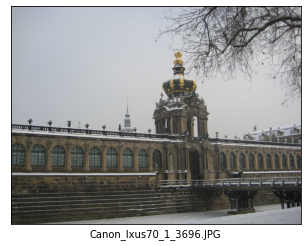

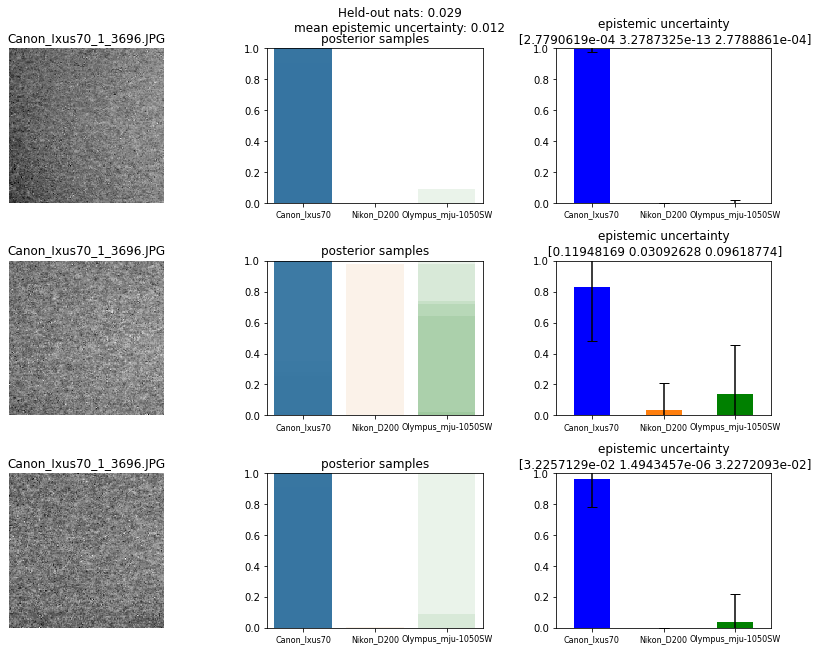

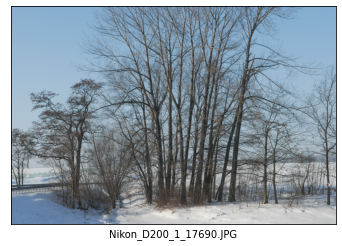

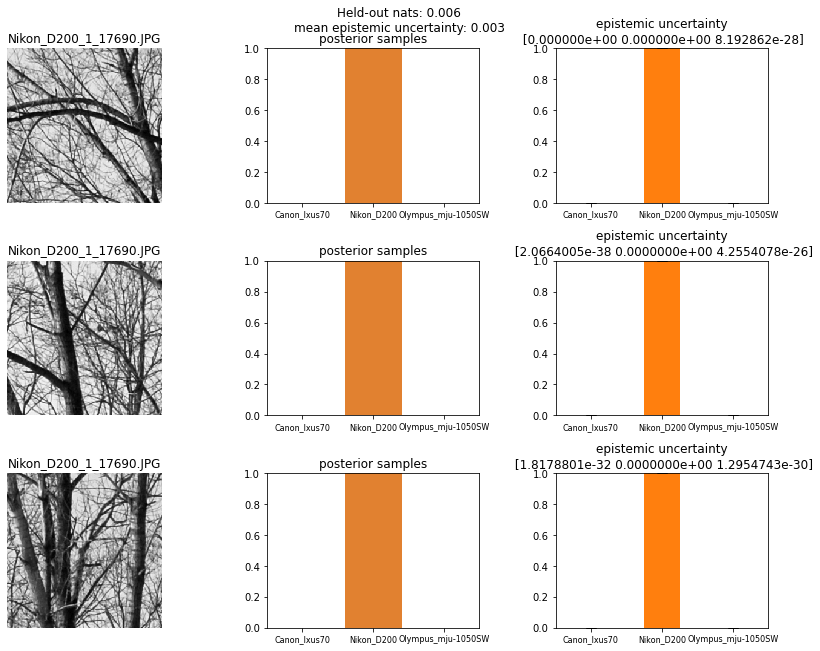

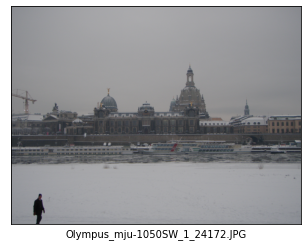

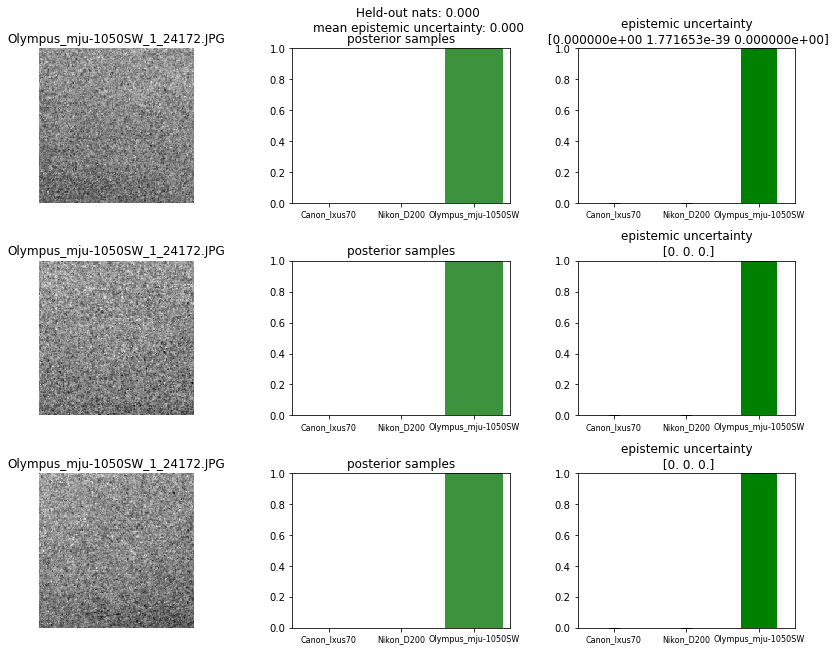

In [18]:
for img in in_examples:
    images, labels = parse_image(img, post_processing=False)
    probs, heldout_log_prob, mean_epistemic = compute_probs(images)
#     plot_held_out(images[:], labels.numpy().decode('utf-8'), probs, heldout_log_prob, mean_epistemic, images.shape[0])
    plot_held_out(images[:3], labels.numpy().decode('utf-8'), probs, heldout_log_prob, mean_epistemic, 3)

## OOD examples by applying JPEG Compression

 ... Held-out nats: 0.224
mean epistemic uncertainty: 0.118

 ... Held-out nats: 0.261
mean epistemic uncertainty: 0.140

 ... Held-out nats: 0.425
mean epistemic uncertainty: 0.240



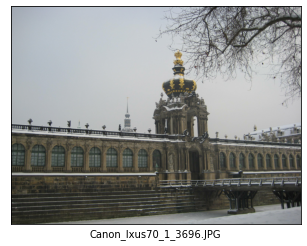

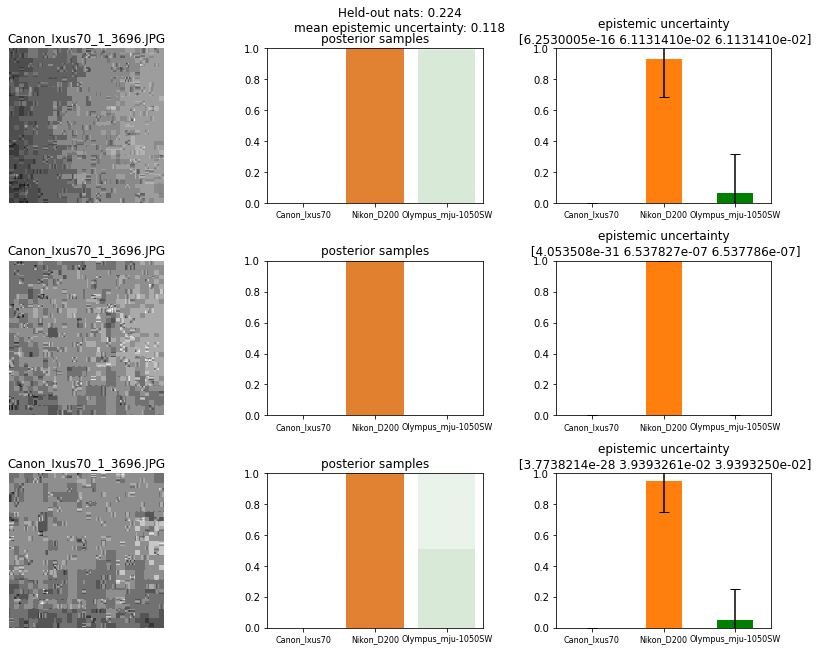

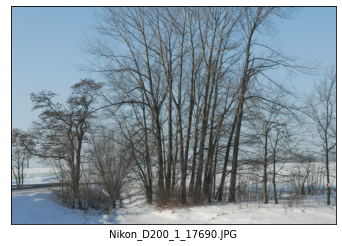

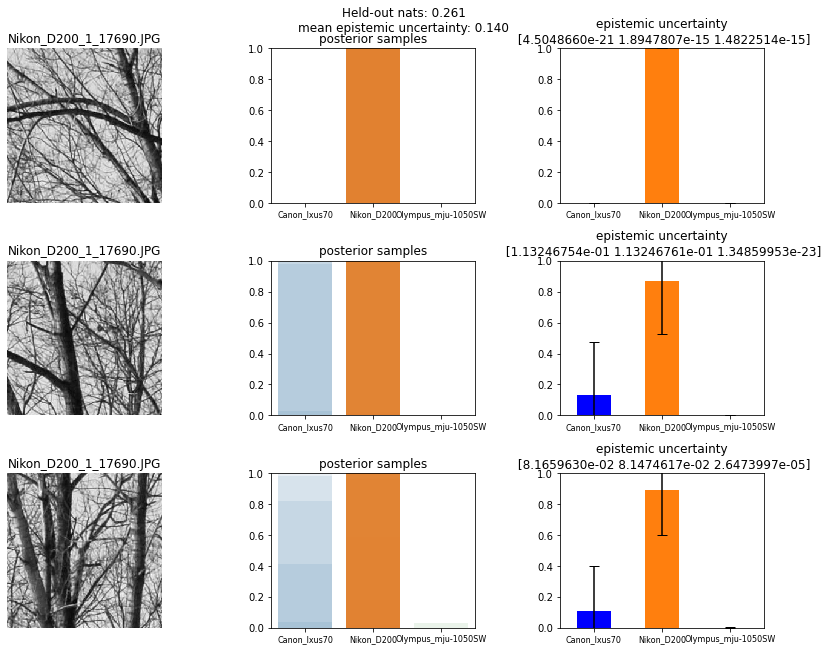

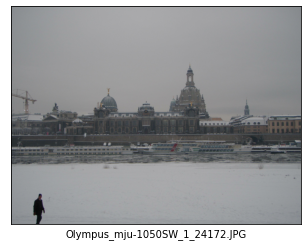

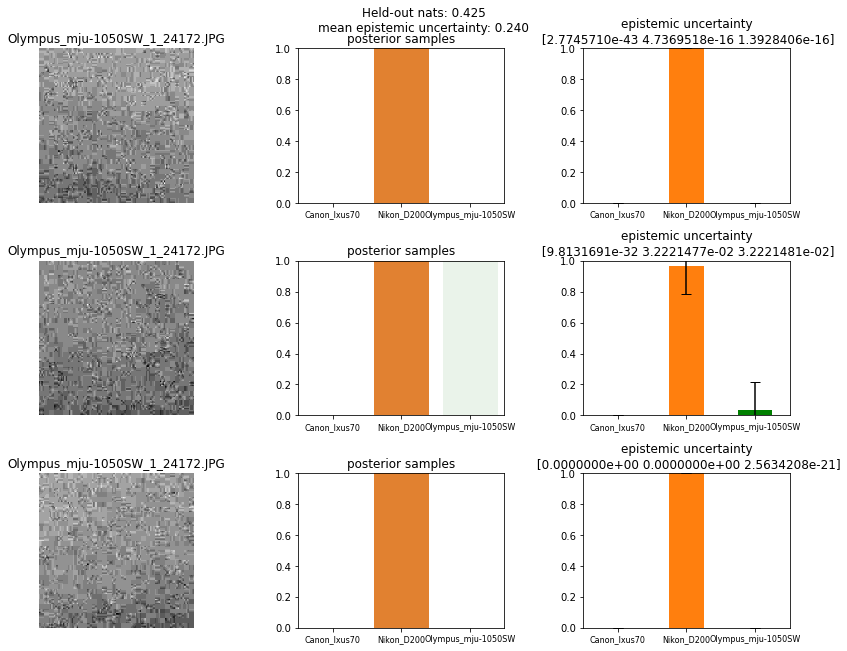

In [19]:
in_iterator = data_preparation.build_dataset('test')
in_images, _ = in_iterator.get_next()
for img in in_examples:
    images, labels = parse_image(img, post_processing='jpeg')
    probs, heldout_log_prob, mean_epistemic = compute_probs(images)
#     show_ood_detection_results(err, in_images, images)
#     plot_held_out(images[:], labels.numpy().decode('utf-8'), probs, heldout_log_prob, mean_epistemic, images.shape[0])
    plot_held_out(images[:3], labels.numpy().decode('utf-8'), probs, heldout_log_prob, mean_epistemic, 3)

## OOD examples by applying Gaussian Blur

 ... Held-out nats: 0.010
mean epistemic uncertainty: 0.004

 ... Held-out nats: -0.000
mean epistemic uncertainty: 0.000

 ... Held-out nats: 0.000
mean epistemic uncertainty: 0.000



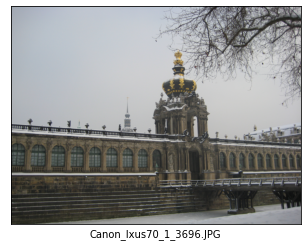

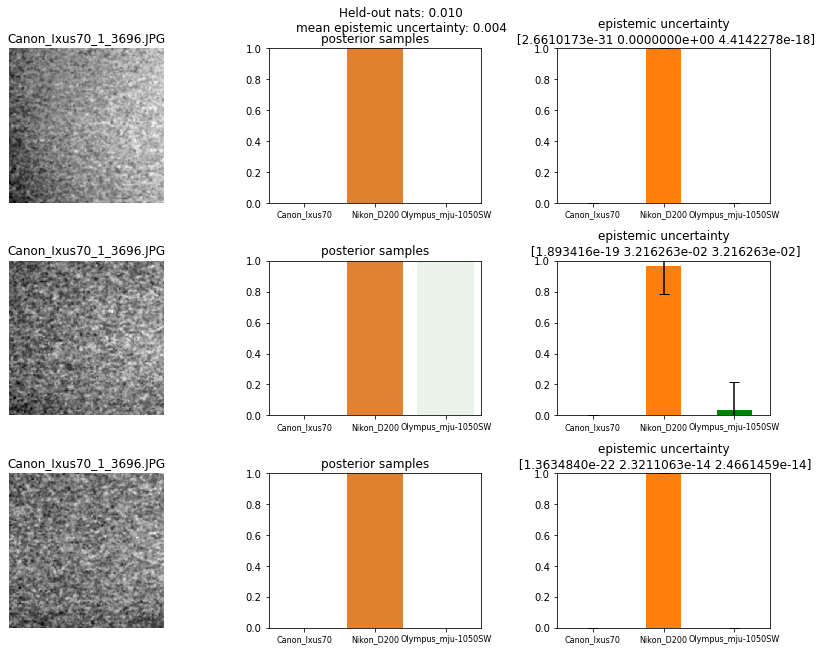

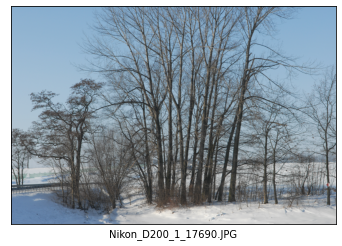

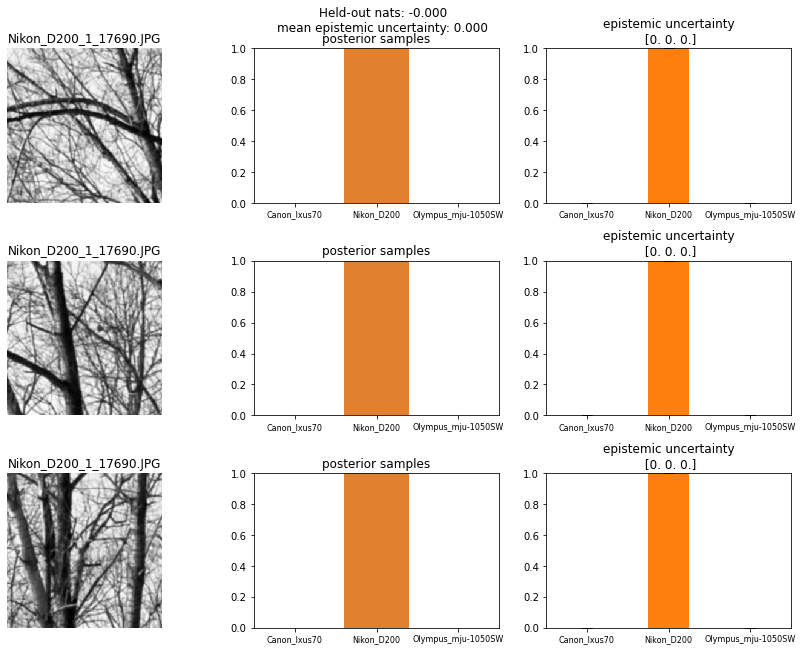

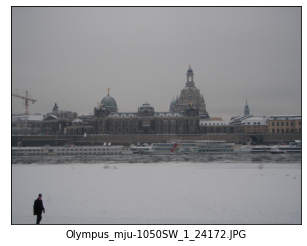

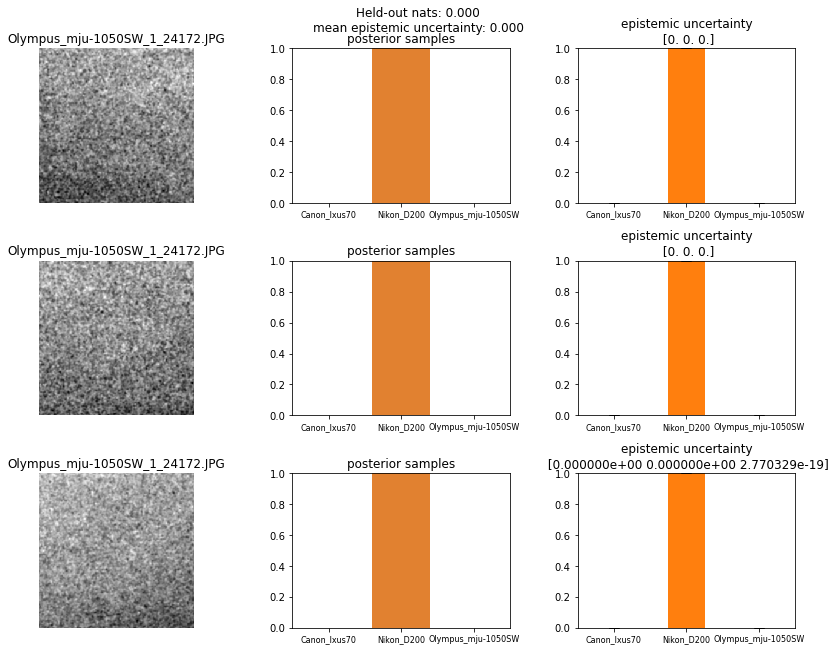

In [20]:
for img in in_examples:
    images, labels = parse_image(img, post_processing='blur')
    probs, heldout_log_prob, mean_epistemic = compute_probs(images)
#     plot_held_out(images[:], labels.numpy().decode('utf-8'), probs, heldout_log_prob, mean_epistemic, images.shape[0])
    plot_held_out(images[:3], labels.numpy().decode('utf-8'), probs, heldout_log_prob, mean_epistemic, 3)

## OOD examples by applying Gaussian Noise

 ... Held-out nats: -0.000
mean epistemic uncertainty: 0.000

 ... Held-out nats: 0.229
mean epistemic uncertainty: 0.145

 ... Held-out nats: 0.000
mean epistemic uncertainty: 0.000



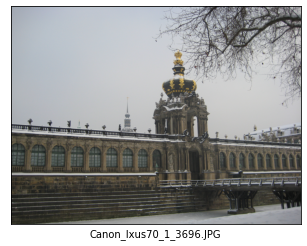

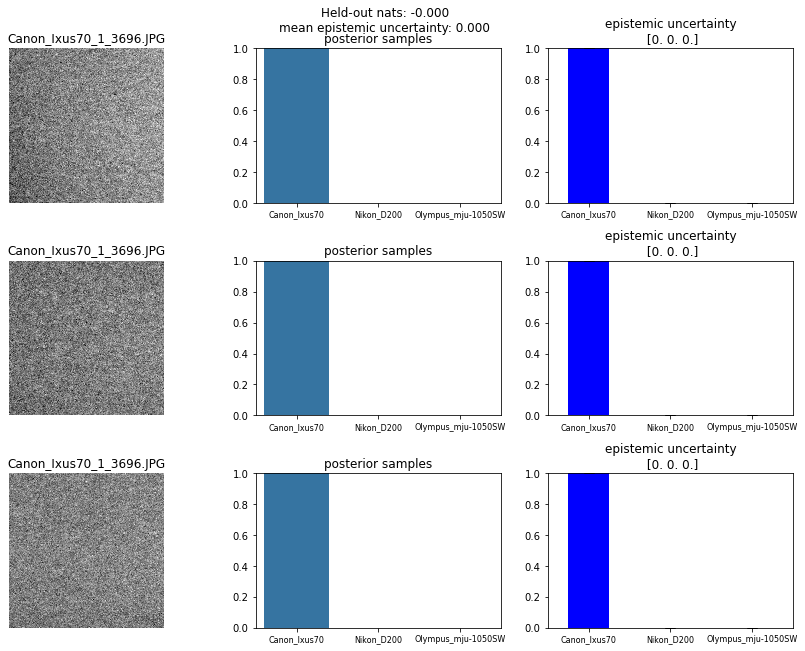

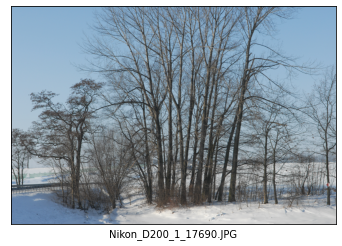

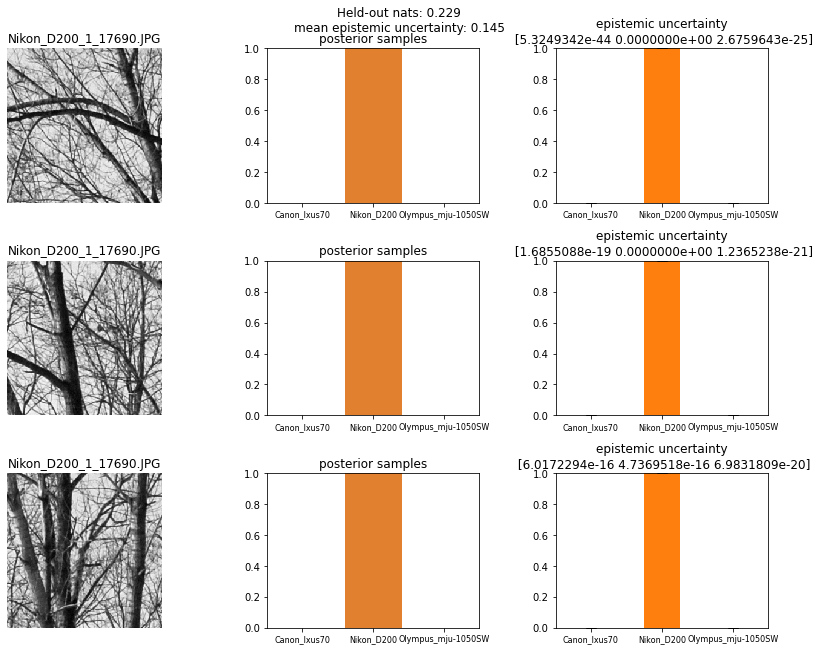

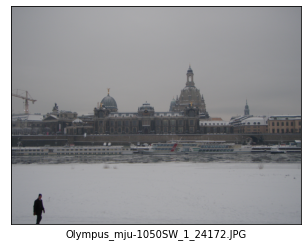

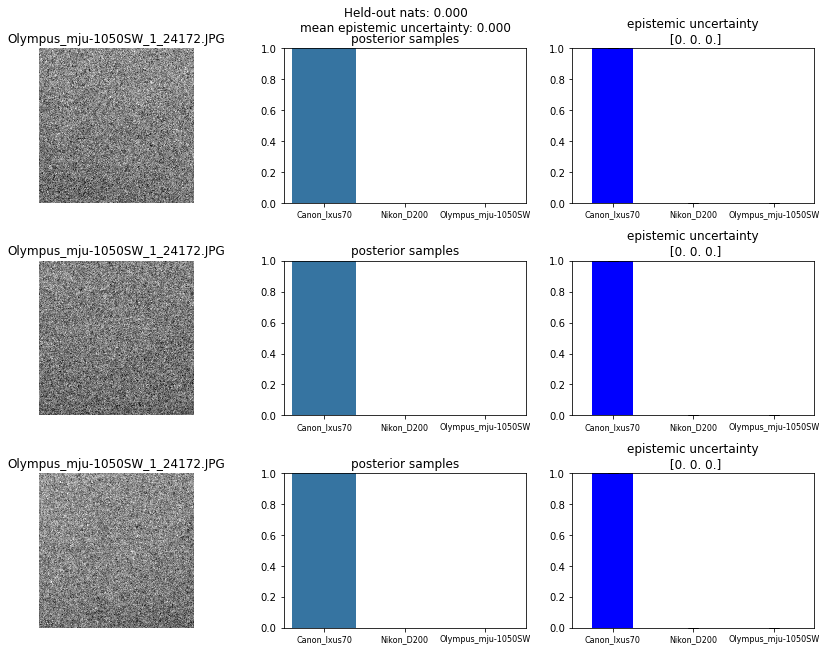

In [21]:
for img in in_examples:
    images, labels = parse_image(img, post_processing='noise')
    probs, heldout_log_prob, mean_epistemic = compute_probs(images)
#     plot_held_out(images[:], labels.numpy().decode('utf-8'), probs, heldout_log_prob, mean_epistemic, images.shape[0])
    plot_held_out(images[:3], labels.numpy().decode('utf-8'), probs, heldout_log_prob, mean_epistemic, 3)

## OOD examples from unseen camera

In [22]:
out_examples = []
for brand_models in params.unseen_brand_models:
    images_dir = os.path.join(params.dresden_images_dir, brand_models)
    samples = np.random.choice(os.listdir(images_dir), 1)
    out_examples.extend([os.path.join(images_dir, s) for s in samples])

 ... Held-out nats: 0.000
mean epistemic uncertainty: 0.000

 ... Held-out nats: -0.000
mean epistemic uncertainty: 0.000

 ... Held-out nats: 0.000
mean epistemic uncertainty: 0.000

 ... Held-out nats: 0.112
mean epistemic uncertainty: 0.061

 ... Held-out nats: 0.007
mean epistemic uncertainty: 0.003



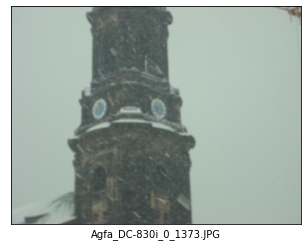

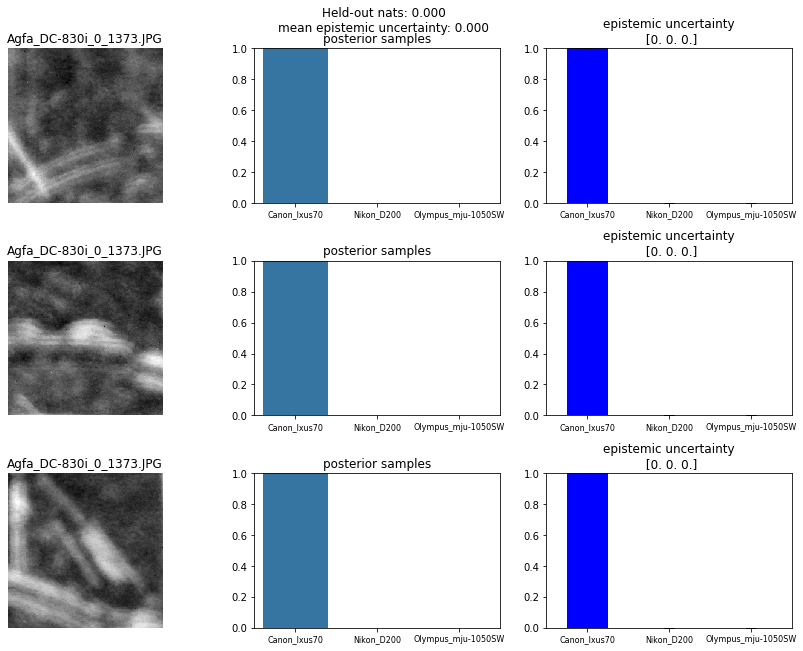

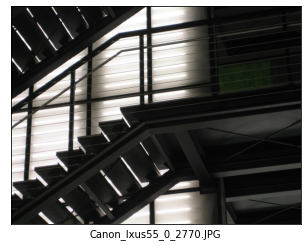

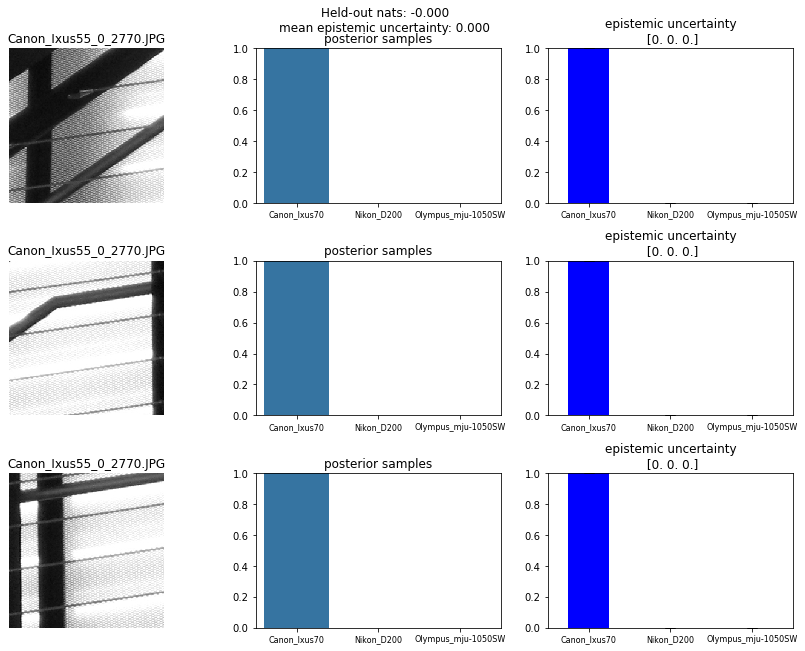

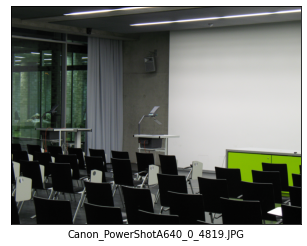

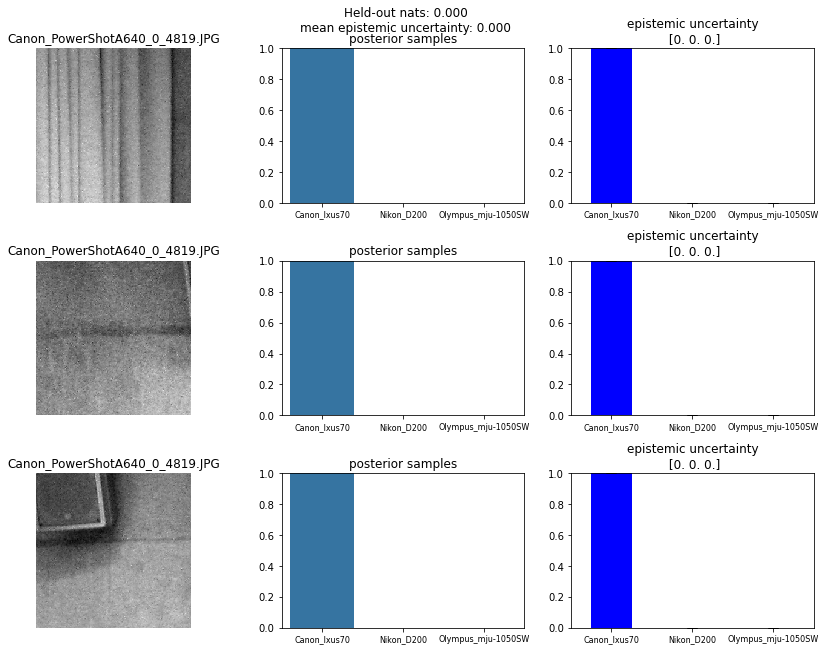

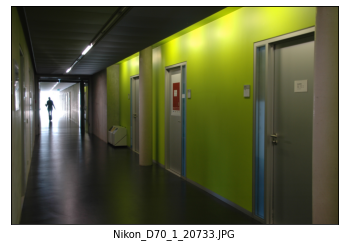

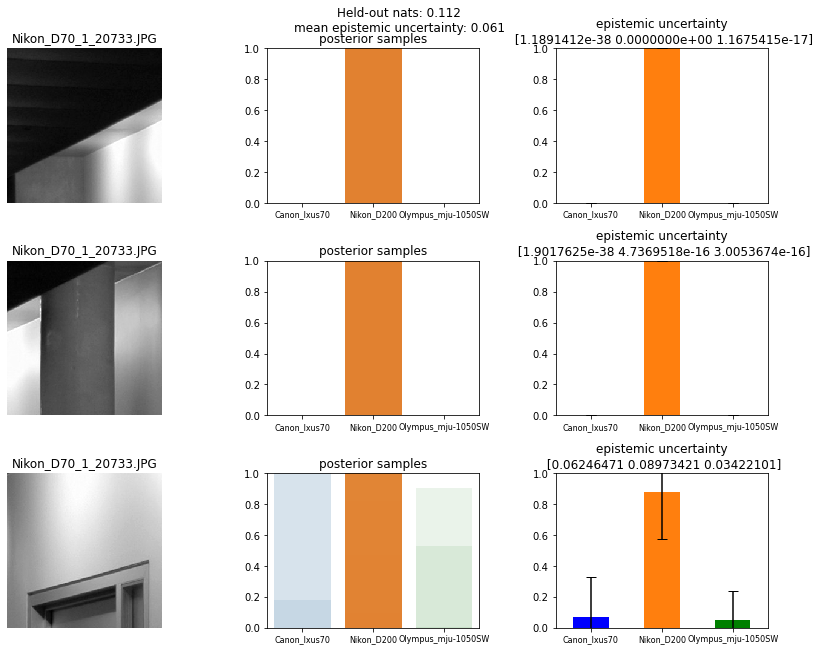

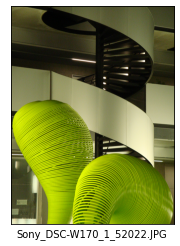

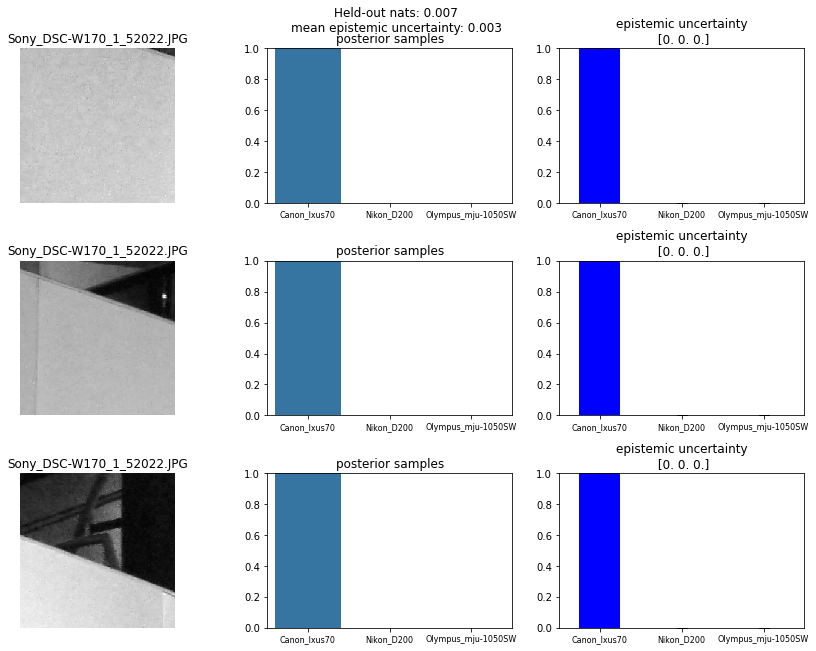

In [23]:
for img in out_examples:
    images, labels = parse_image(img)
    probs, heldout_log_prob, mean_epistemic = compute_probs(images)
#     plot_held_out(images[:], labels.numpy().decode('utf-8'), probs, heldout_log_prob, mean_epistemic, images.shape[0])
    plot_held_out(images[:3], labels.numpy().decode('utf-8'), probs, heldout_log_prob, mean_epistemic, 3)

## OOD examples from my phone

 ... Held-out nats: 0.007
mean epistemic uncertainty: 0.003

 ... Held-out nats: 0.000
mean epistemic uncertainty: 0.000

 ... Held-out nats: 0.220
mean epistemic uncertainty: 0.126

 ... Held-out nats: 0.000
mean epistemic uncertainty: 0.000



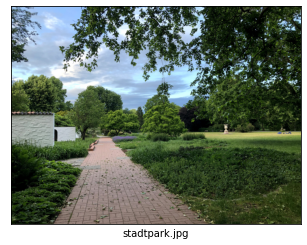

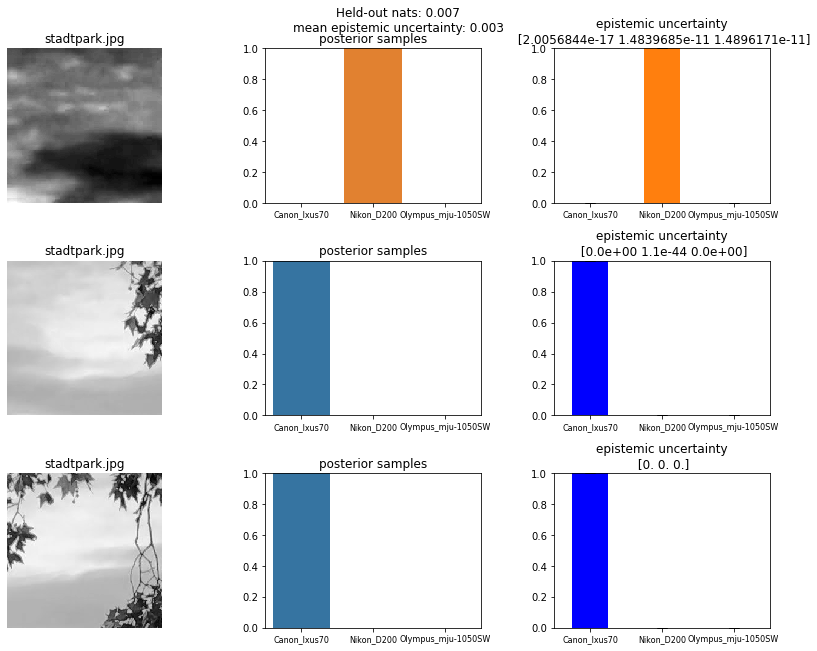

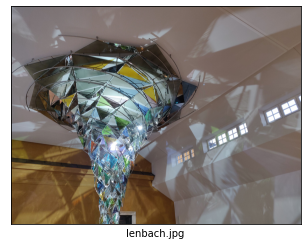

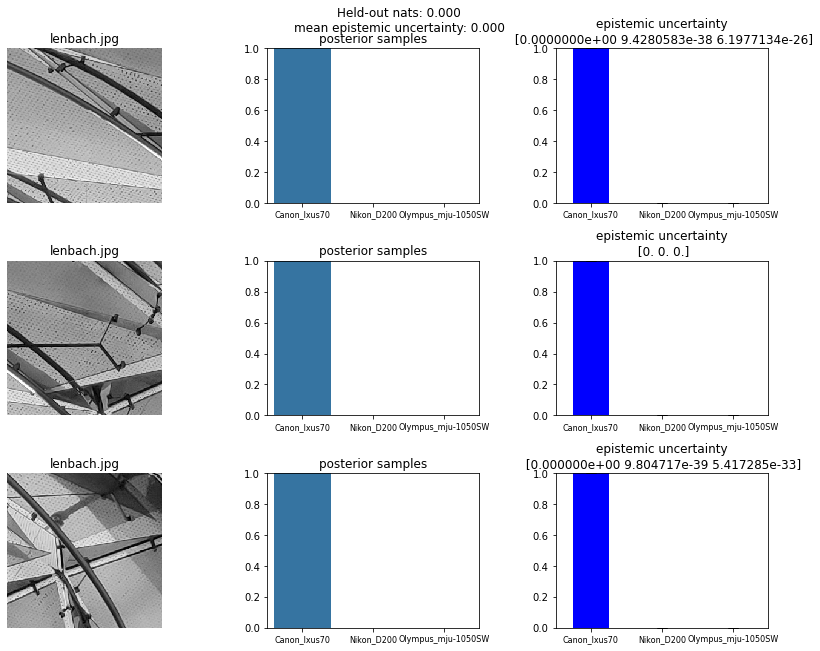

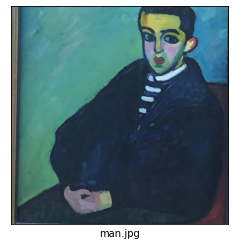

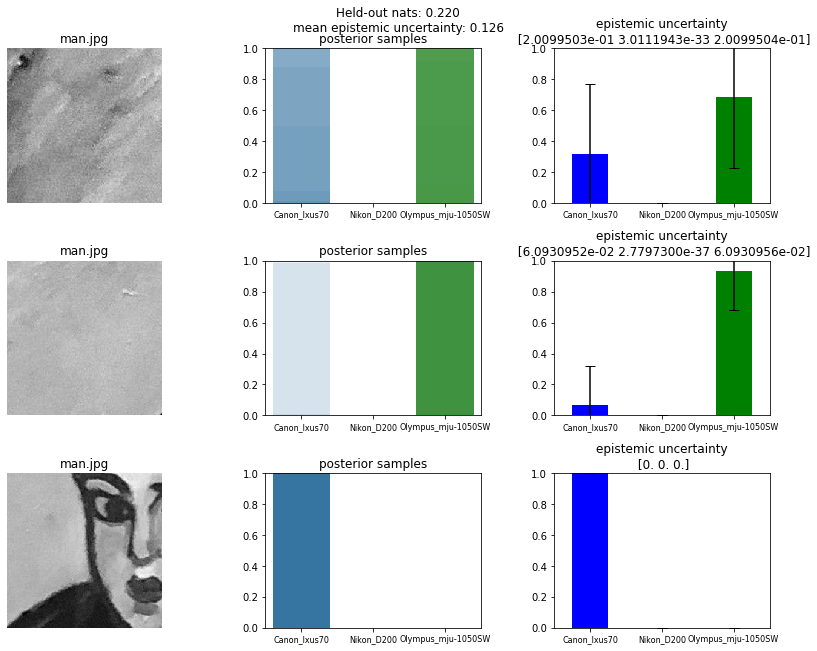

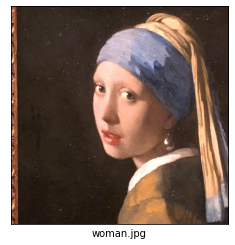

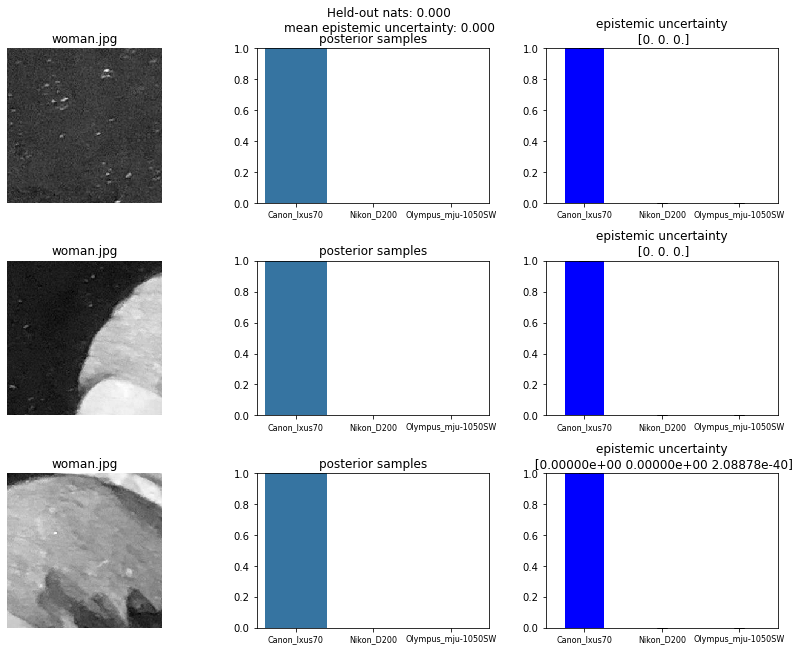

In [24]:
img_names = ['stadtpark', 'lenbach', 'man', 'woman']
ood_dir = 'data/ood/' + 'woman' + '.jpg'
filenames = ['data/ood/' + filename + '.jpg' for filename in img_names]

for img in filenames:
    images, labels = parse_image(img, post_processing=False)
    probs, heldout_log_prob, mean_epistemic = compute_probs(images)
#     plot_held_out(images[:], labels.numpy().decode('utf-8'), probs, heldout_log_prob, mean_epistemic, images.shape[0])
    plot_held_out(images[:3], labels.numpy().decode('utf-8'), probs, heldout_log_prob, mean_epistemic, 3)

In [25]:
model.summary()

Model: "bnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  78        
_________________________________________________________________
conv2d_flipout (Conv2DFlipou multiple                  28320     
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip multiple                  307264    
_________________________________________________________________
conv2d_flipout_2 (Conv2DFlip multiple                  204864    
_________________________________________________________________
conv2d_flipout_3 (Conv2DFlip multiple                  16512     
_________________________________________________________________
dense_flipout (DenseFlipout) multiple                  2509000   
_________________________________________________________________
dense_flipout_1 (DenseFlipou multiple                  80200   

mean of mean is 0.0026827293913811445, mean variance is 0.05875765532255173


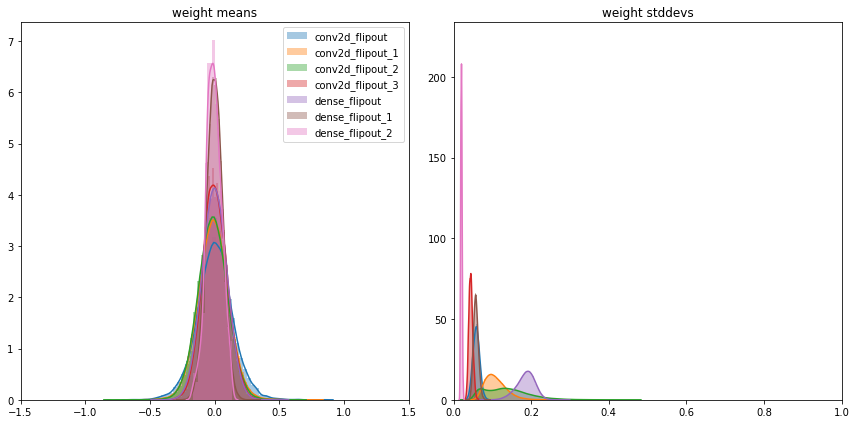

In [26]:
names = [layer.name for layer in model.layers 
        if 'flipout' in layer.name]
# dense_flipout/kernel_posterior_loc:0
qm_vals = [layer.kernel_posterior.mean() 
        for layer in model.layers
        if 'flipout' in layer.name]
qs_vals = [layer.kernel_posterior.stddev() 
        for layer in model.layers
        if 'flipout' in layer.name]
plot_weight_posteriors(names, qm_vals, qs_vals)
print("mean of mean is {}, mean variance is {}".
      format(tf.reduce_mean(qm_vals[0]),
      tf.reduce_mean(qs_vals[0])))